# IMDB part IV : the final chapter

In part 1, 2 and 3 of this series of post I cleaned, gathered and explored a data set of 5000 movies taken from IMDB by the Kaggle user deepMatrix. Now I will apply three different machine learning algorithm to create a model which will predict the profitability of a movie by looking at features that are available in pre-production. 

In the first part of this article, I will use the support machine vector algorithm, the XGBoost algorithm and a simple neural network to predict the revenue a movie will make at the American box-office. After using those algorithms in a regression context, I'll use them to label the movie either profitable or non-profitable. Using those algorithms in both context will be a good occasion to talk about the limitation of each and how the formulation of a problem can affect the performance of a model.

As usual, the first thing I do is load the necessary library and the data set.

In [2]:
library(dplyr)
library(data.table)
library(bit64)
library(plotly)
library(corrplot)
options(scipen=999)
library(xgboost)
library(psych)
library(e1071)
library(neuralnet)

In [3]:
movies <- fread("movie_exploration.csv",stringsAsFactors = F)

Then I choose the variables I could use in the model and classify them by type. Remember that some variables in the data set are the measure of phenomenons who should happen after the release of the movie, so they are useless for my model and I don't list them.

In [3]:
cont_var<-names(movies[,c("duration","director_facebook_likes","actor_3_facebook_likes","actor_1_facebook_likes",
                           "cast_total_facebook_likes","facenumber_in_poster","actor_2_facebook_likes","budget_2016",
                          "profit","gross_2016","dir_mean_gross","act_1_mean_gross","act_2_mean_gross","act_3_mean_gross")])

cath_var<-names(movies[,c("color","language","country","content_rating","title_year","aspect_ratio")])

genre_var<-names(movies[,c("genres_Action","genres_Adventure","genres_Animation","genres_Biography","genres_Comedy",
                        "genres_Crime","genres_Documentary","genres_Drama","genres_Family","genres_Fantasy","genres_Film_Noir",
                        "genres_Game_Show","genres_History","genres_Horror","genres_Music","genres_Musical","genres_Mystery",
                        "genres_News","genres_Reality_TV","genres_Romance","genres_Sci_Fi","genres_Short","genres_Sport",
                        "genres_Thriller","genres_War","genres_Western")])

Since most functions in R can't handle the categorical variable, I coded them in dummy variable, like I did for the genre variable.

In [4]:
for (f in cath_var) {
    movies <- cbind(movies, dummy.code(movies[[f]]))
}

I created two sets of sample to train and test the different model. When needed, I will split the train data set to cross validate the model.

In [5]:
set.seed(383)
row_sample<-sample(1:nrow(movies),0.8*nrow(movies),replace=FALSE)
train<-movies[row_sample]
test<-movies[!row_sample]

# Regression
## SVM

The first algorithm I'll use is the support vector machine. I choose this algorithm since it's pretty versatile, capable of doing linear and non-linear regression and it's quite fast. So it's a perfect algorithm to do a base model. 

Since the efficiency of the SVM algorithm decrease with the number of dimensions of our model, I started by making a simple model with only a handful of variables and then made another more complex to see how what is the optimal number of variable to include in the model. The variable used are the one who had a correlation coefficient of at least 0.2 with the "gross_2016" variable. 

In [14]:
base.var<-names(movies[,c("duration","director_facebook_likes","actor_3_facebook_likes","budget_2016",
                          "dir_mean_gross","act_1_mean_gross","act_2_mean_gross","act_3_mean_gross", "gross_2016")])
train.svm.base<-train[,base.var,with=FALSE]
test.svm.base<-test[,base.var,with=FALSE]

train.svm.base<-train.svm.base[complete.cases(train.svm.base)]
test.svm.base<-test.svm.base[complete.cases(test.svm.base)]

Since the R function can scale the continuous variables, I can pass them directly as an argument without normalization.

In [15]:
model.svm.base <- svm(gross_2016~.,  scale = TRUE, data = train.svm.base)

In [16]:
resultats.svm.base <- predict(object = model.svm.base, newdata = train.svm.base)

In [17]:
str(resultats.svm.base)

 Named num [1:2818] 139158295 33673405 14807203 32264724 78546455 ...
 - attr(*, "names")= chr [1:2818] "1" "2" "3" "4" ...


I chose the root mean square error to measure the difference between the real values and our model prediction. R doesn't provide a function to calculate the rmse so I have written my own.

In [9]:
rmse <- function(error)
{
    sqrt(mean(error^2,na.rm=TRUE))
}

In [20]:
error <- train.svm.base$gross_2016 - resultats.svm.base
rmse(error) 

[1] 71758341

After doing a base model with the defaul parameter, I now must tune the model by choosing the best value of the parameter epsilon and the cost in the Lagrange transformation. Choosing a good value for those parameter will help the model fit the data without overfitting. I looked at the value of epsilon between 0 and 1 by increment of 0.1 and the cost value of 4 and 8. If needed, I'll look at other values.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 epsilon cost
     0.3    4

- best performance: 6047948505755821 



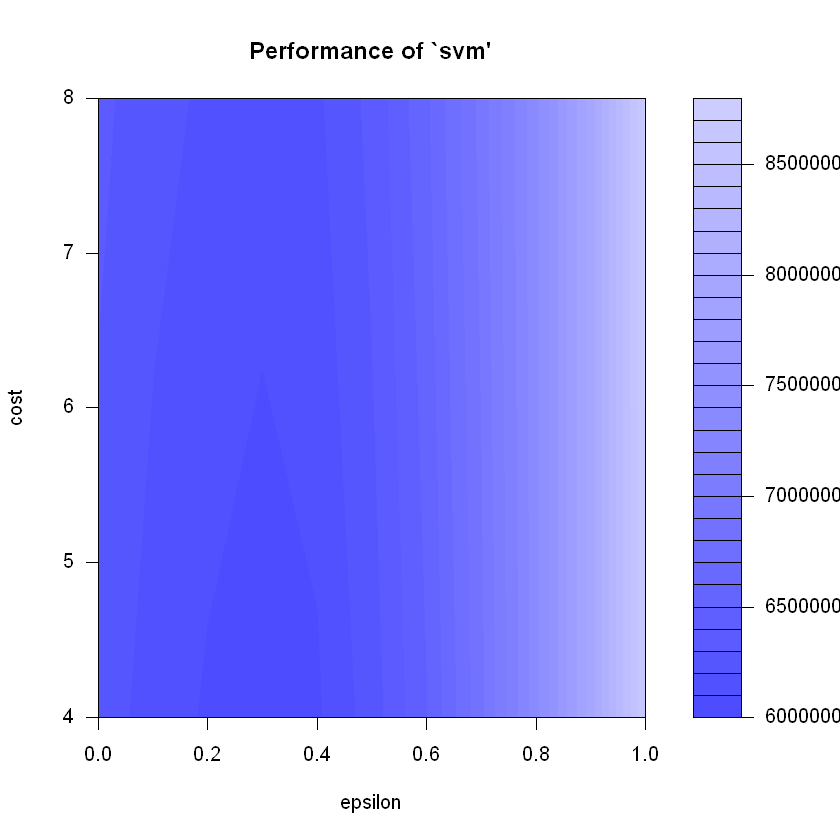

In [23]:
options(warn=-1)
svm.base.tune <- tune(svm, gross_2016~., data = train.svm.base,
              ranges = list(epsilon = seq(0,1,0.1), cost = 2^(2:3))
)
options(warn = 1)
print(svm.base.tune)
plot(svm.base.tune)

The darker area on this plot is the region where the to optimal value of epsilon and cost is located. Since this region seems to be located between e=0.1, e=0.5 and cost<4, I search deeper in this region.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 epsilon cost
    0.26    2

- best performance: 6023072951120205 



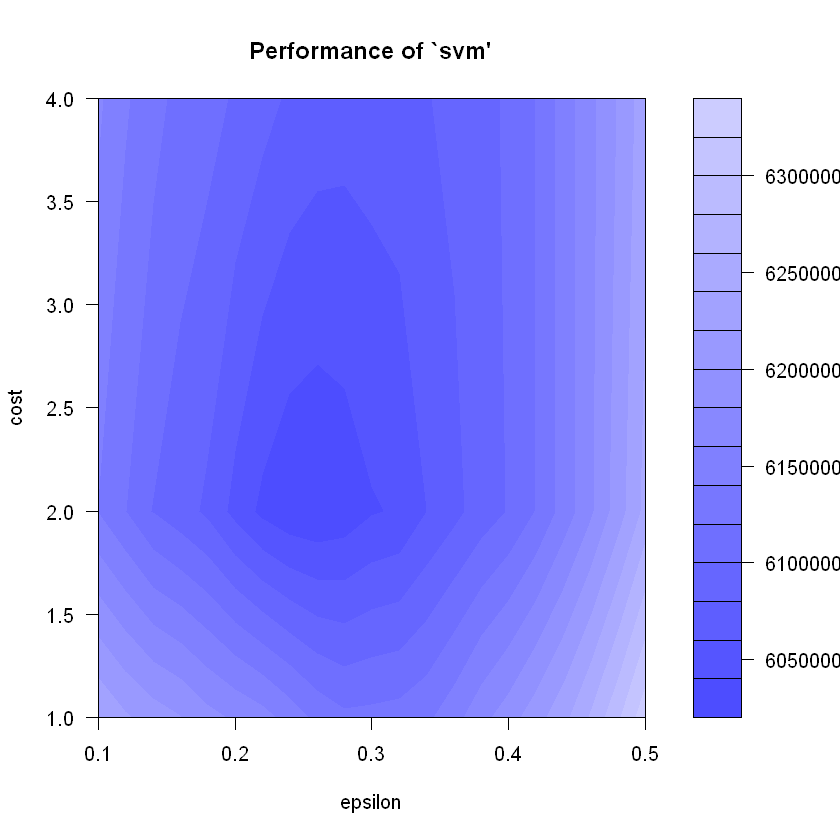

In [25]:
options(warn=-1)
svm.base.tune2 <- tune(svm, gross_2016~., data = train.svm.base,
              ranges = list(epsilon = seq(0.1,0.5,0.02), cost = 2^(0:2))
)
options(warn = 1)
print(svm.base.tune2)
plot(svm.base.tune2)

Now the region is more define. Let focus on the region e=0.2, e=0.3, cost=1 and cost=4.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 epsilon cost
    0.25    2

- best performance: 6024713655296222 



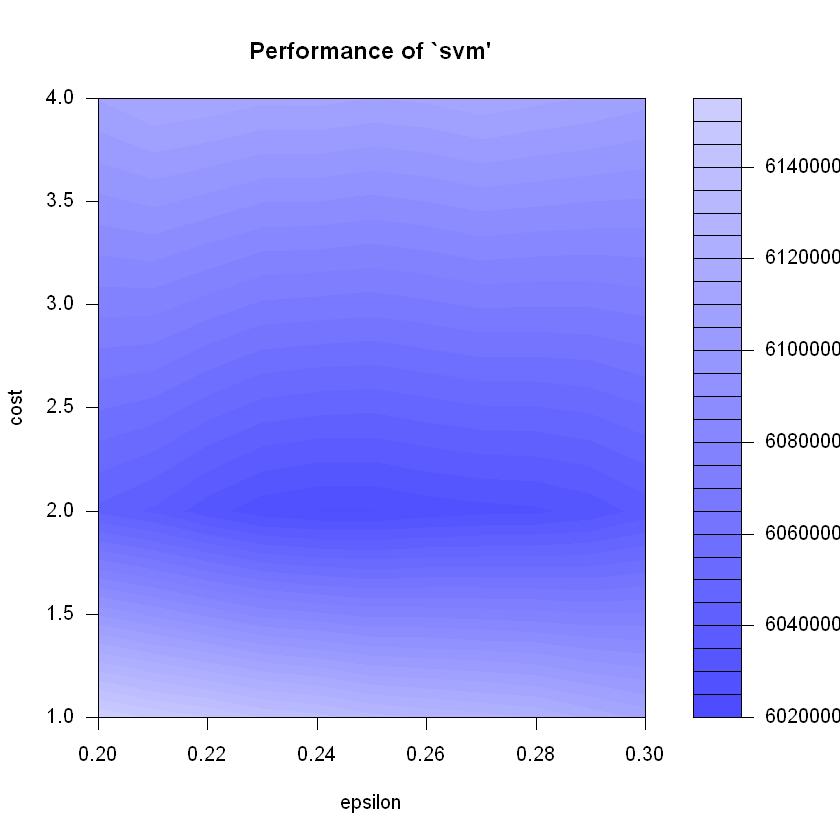

In [26]:
options(warn=-1)
svm.base.tune3 <- tune(svm, gross_2016~., data = train.svm.base,
              ranges = list(epsilon = seq(0.2,0.3,0.01), cost = 2^(0:2))
)
options(warn = 1)
print(svm.base.tune3)
plot(svm.base.tune3)

In [27]:
svm.base.tune3$best.model


Call:
best.tune(method = svm, train.x = gross_2016 ~ ., data = train.svm.base, 
    ranges = list(epsilon = seq(0.2, 0.3, 0.01), cost = 2^(0:2)))


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  2 
      gamma:  0.125 
    epsilon:  0.25 


Number of Support Vectors:  1328


Now that I have the optimal value of the hyperparameter, I can make the prediction for the test set.

In [34]:
model.svm.base.tune <- svm.base.tune3$best.model
model.svm.base.tune.pred <- predict(model.svm.base.tune, test.svm.base) 
 
error <- test.svm.base$gross_2016 - model.svm.base.tune.pred    
rmse(error) 

[1] 85383309

In [67]:
svm_base_pred<-plot_ly(test.svm.base) %>%
add_trace(y=~test.svm.base$gross_2016, name = 'test set', type = 'scatter',mode = 'lines+markers' )%>%
add_trace(y=~model.svm.base.tune.pred ,name = 'predictions', type = 'scatter',mode = 'markers' )%>%
layout(title = 'Gross revenu of movies in the data set and prediction from the svm algorithm',
         xaxis = list(title = '', zeroline = TRUE),
         yaxis = list(title = 'Gross'))

embed_notebook(svm_base_pred,file=paste0("plotlyJupyterHTML/","svm_base_pred",".html"))

ERROR: Error in is.data.frame(data): objet 'test.svm.base' introuvable


In [33]:
write.svm(model.svm.base.tune , svm.file = "model.svm.base.tune.svm", scale.file = "IMDB-regression.scale")

We can see that the model has trouble predicting the outlier since most of the predicted point are between 0 and 200 million dollars. Also if we zoom we see taht the model is quite good at predicting if the shape of the curve, but miss the real value of the variable "gross_2016". Let's see if adding more feature will help the model. 

In [51]:
train_svm<-train[,c(cont_var),with=FALSE]
test_svm<-test[,c(cont_var),with=FALSE]

After coping all the continous variable in the data set, I drop the "profit" variables and I keep only the row without missing values.

In [52]:
train_svm <- train_svm[,!"profit",with=FALSE]
test_svm  <- test_svm[,!"profit",with=FALSE]

train_svm <- train_svm[complete.cases(train_svm)]
test_svm  <- test_svm[complete.cases(test_svm)]

In [53]:
model.svm.cont <- svm(gross_2016~.,  scale = TRUE, data = train_svm)

In [54]:
resultats.svm.cont <- predict(object = model.svm.cont, newdata = train_svm)

In [56]:
error <- train_svm$gross_2016 - resultats.svm.base
rmse(error) 

Warning message in train_svm$gross_2016 - resultats.svm.base:
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"

[1] 94543061

Using all the continuous variables to the model doesn't make it more precice. Like most algorithm, the SVM algorithm is less accurate the more feature we use. Let's see if tuning the model can help.

In [57]:
options(warn=-1)
svm.cont.tune <- tune(svm, gross_2016~., data = train_svm,
              ranges = list(epsilon = seq(0,1,0.1), cost = 2^(2:9))
)
options(warn = 1)
print(svm.cont.tune)
plot(svm.cont.tune)

ERROR: Error in print(svm.tune): objet 'svm.tune' introuvable



Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 epsilon cost
     0.2    4

- best performance: 6168608417283058 



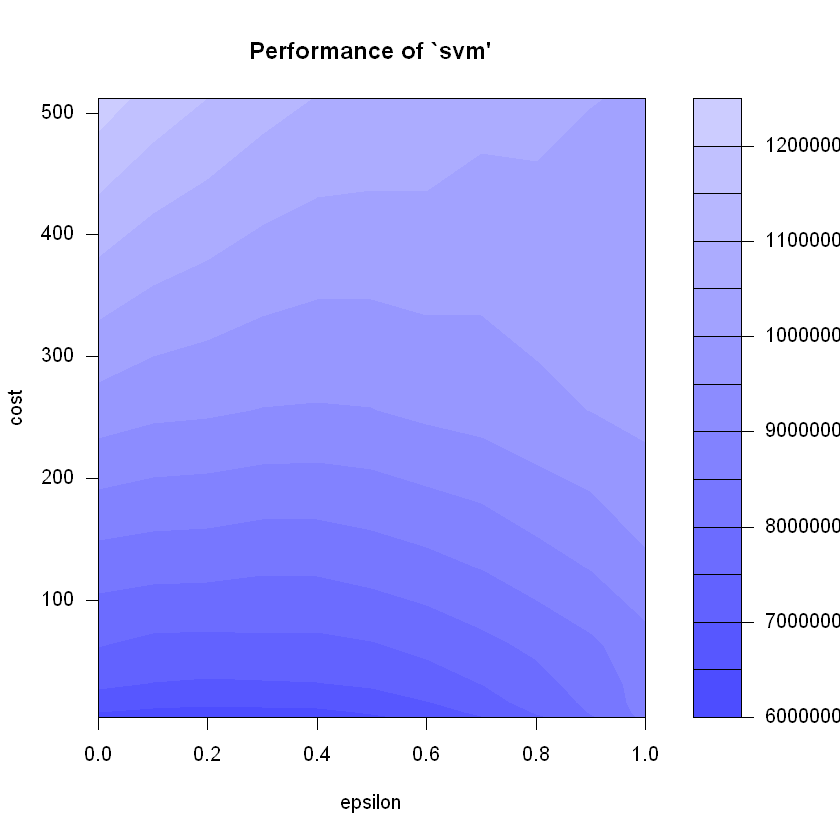

In [58]:
options(warn = 1)
print(svm.cont.tune)
plot(svm.cont.tune)

In [ ]:
options(warn=-1)
svm.cont.tune2 <- tune(svm, gross_2016~., data = train_svm,
              ranges = list(epsilon = seq(0,0.5,0.2), cost = 2^(0:2))
)
options(warn = 1)
print(svm.cont.tune2)
plot(svm.cont.tune2)

In [59]:
svm.cont.tune$best.model


Call:
best.tune(method = svm, train.x = gross_2016 ~ ., data = train_svm, 
    ranges = list(epsilon = seq(0, 1, 0.1), cost = 2^(2:9)))


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  4 
      gamma:  0.08333333 
    epsilon:  0.2 


Number of Support Vectors:  1519


In [61]:
model.svm.cont.tune <- svm.cont.tune$best.model
model.svm.cont.tune.pred <- predict(model.svm.cont.tune, test_svm) 
error <- test_svm$gross_2016 - model.svm.cont.tune.pred  
rmse(error) 

[1] 86767052

Adding features to the model didn't help to reduce the root mean square error of the model. So for now, 85383309 is the mark to beat with the other algorithm.

# Regression with Xgboost
This algorithm has for advantage to be really fast, he can handle very well sparse matrix and missing data.

Since most variables in the data set are not correlated to the variable of interest, using all of them in the model is not really a good idea: it will just add a lot of noise to the model and can create some overfitting problems. But this algorithm is really good at picking the important feature in a model and since he is so fast, I took the opposite approach I used for the SVM algorithm: I use the most feature possible for my first use of this algorithm and I will prune the feature as a go on.

In [6]:
variable_names <- names(train[,!c("budget","gross","profit","budget_us","currency","imdb_score","director_name",
                                  "num_user_for_reviews","movie_imdb_link","num_voted_users","num_critic_for_reviews",
                                  "movie_facebook_likes","genres","movie_title","plot_keywords","actor_1_name",
                                 "actor_2_name","actor_3_name","V1")])

In [7]:
train_xgb<-train[,variable_names,with=FALSE]
test_xgb<-test[,variable_names,with=FALSE]

Since I already coded the cathegorical variables as dummy variables, I excluded them from the data sets.

In [8]:
train_xgb <- train_xgb[,!cath_var,with=FALSE]
test_xgb <- test_xgb[,!cath_var,with=FALSE]

Then I normalize the continuous variables and coded the missing information. 

In [10]:
for (f in intersect(variable_names,cont_var)) {
  if (max(train_xgb[[f]],na.rm=TRUE)!=1 | min(train_xgb[[f]],na.rm=TRUE)!=0) {
    train_xgb[[f]] <- scale(train_xgb[[f]])
    test_xgb[[f]]  <- scale(test_xgb[[f]])
  }
}

train_xgb[is.na(train_xgb)]<--1
test_xgb[is.na(test_xgb)]<--1

To be able to use xgboost, I have to feed the function a matrix, so I have to convert the data frame.

In [11]:
drop_col_names <- names(train[,c("gross_2016")])
str(drop_col_names)

 chr "gross_2016"


In [12]:
train_xgb_matrix <- xgb.DMatrix(data.matrix(train_xgb[,!drop_col_names,with=FALSE]),
                                label=train_xgb$gross_2016,missing=-1)
test_xgb_matrix  <- xgb.DMatrix(data.matrix(test_xgb[,!drop_col_names,with=FALSE]),
                                label=test_xgb$gross_2016,missing=-1)

Then I set the pameters for the algorithm. Since the data is normalize, I'm not interested in having the rmse printed for each iteration of the algorithm, so I didn't initialise the watchlist argument. Also, after trial and error, I realised that 500 iterations where enoupht for this data.

In [13]:
param <- list(  objective           = "reg:linear", 
                booster             = "gblinear",
                eval_metric         = "rmse"
                )

In [14]:
set.seed(383)
model_xgb <- xgb.train(   params          = param, 
                    data                  = train_xgb_matrix, 
                    nrounds               = 500,
                    verbose               = 0, 
                    early_stopping_rounds = 20,
                    missing               = -1,
                    maximize              = FALSE)

Next I took the model greated by the algorithm and predited how much that each movie in the data set should gross at the box-office and compare those prediction with the real values. To do so, I scale the prediction to match the data set and calculated the rmse.

In [15]:
pred<-predict(model_xgb,test_xgb_matrix)

In [16]:
scaleList <- list(scale = attr(train_xgb$gross_2016, "scaled:scale"),
    center = attr(train_xgb$gross_2016, "scaled:center"))

pred_unscale <- pred * scaleList$scale + scaleList$center
error<-pred_unscale-test_xgb$gross_2016
rmse(error)

[1] 95480460

In [21]:
xgb.save(model_xgb,fname="model_xgb_1_tune")

[1] TRUE

This model did worst than the best SVM model: maybe the cathegorical variables don't offer usefull information to the algorithm. In the next model, I'll use only the continous variables that I choose for the last model.

In [41]:
train_xgb <- train_xgb[,intersect(variable_names,cont_var),with=FALSE]
test_xgb <- test_xgb[,intersect(variable_names,cont_var),with=FALSE]

In [42]:
train_xgb_matrix <- xgb.DMatrix(data.matrix(train_xgb[,!drop_col_names,with=FALSE]), label=train_xgb$gross_2016,missing=NA)
test_xgb_matrix  <- xgb.DMatrix(data.matrix(test_xgb[,!drop_col_names,with=FALSE]), label=test_xgb$gross_2016,missing=NA)

In [44]:
set.seed(383)
model_xgb <- xgb.train(   params          = param, 
                    data                  = train_xgb_matrix, 
                    nrounds               = 1000, # changed from 300
                    verbose               = 0, 
                    early_stopping_rounds = 20,
                    #watchlist             = watchlist,
                    missing               = -1,
                    maximize              = FALSE)

In [45]:
pred<-predict(model_xgb,test_xgb_matrix)
pred_unscale <- pred * scaleList$scale + scaleList$center
error<-pred_unscale-test_xgb$gross_2016
rmse(error)

[1] 83959484

In [50]:
xgb.save(model_xgb,fname="model_xgb_cont_var")

[1] TRUE

Dropping the cathegorical variables help the xgboost algorithm greatly! Let's see if using even less variable will help us make a better model. For the next model, I used only the variables whom where at least midly correlated with the "gross_2016" variable.

In [50]:
min_var<-names(movies[,c("budget_2016","gross_2016","dir_mean_gross","act_1_mean_gross","act_2_mean_gross","act_3_mean_gross")])

In [51]:
train_xgb <- train_xgb[,min_var,with=FALSE]
test_xgb <- test_xgb[,min_var,with=FALSE]

In [52]:
train_xgb_matrix <- xgb.DMatrix(data.matrix(train_xgb[,!drop_col_names,with=FALSE]), label=train_xgb$gross_2016,missing=NA)
test_xgb_matrix  <- xgb.DMatrix(data.matrix(test_xgb[,!drop_col_names,with=FALSE]), label=test_xgb$gross_2016,missing=NA)

In [64]:
set.seed(383)
model_xgb_tune_1 <- xgb.train(   params          = param, 
                    data                  = train_xgb_matrix, 
                    nrounds               = 1000, # changed from 300
                    verbose               = 0, 
                    early_stopping_rounds = 20,
                    #watchlist             = watchlist,
                    missing               = -1,
                    maximize              = FALSE)

In [65]:
pred<-predict(model_xgb_tune_1,test_xgb_matrix)
pred_unscale <- pred * scaleList$scale + scaleList$center
error<-pred_unscale-test_xgb$gross_2016
rmse(error)

[1] 83748393

This model is the more efficient so far, but I used almost only the default parameter of the xgboost algorithm to do it. By tuning the hyperparameter I should be able to make a more efficient model to predict the gross of the movie in the test set. In the cell below, I calculated the rmse of different model using a value of eta from 0 to 0.99 by 0.01 increment. The cross validation is made using a 5 fold cross validation.

In [34]:
xgb_mse<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,0.99,0.01)){
    set.seed(383)
     model_xgb_cv <- xgb.cv(params=param, eta=i, data = train_xgb_matrix, nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse<-rbind(xgb_mse,c("index"=i,lapply( model_xgb_cv,function(x) mean(x))))
}

In [66]:
xgb_mse_plot<-plot_ly(xgb_mse) %>%
add_trace(x=~index,y=~test.rmse.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the rmse during the cross validation',
         xaxis = list(title = 'eta', zeroline = TRUE),
         yaxis = list(title = 'rmse'))
embed_notebook(xgb_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_mse_plot",".html"))

In [63]:
xgb_mse[xgb_mse$test.rmse.mean==min(xgb_mse$test.rmse.mean,na.rm=TRUE),]

,index,train.rmse.mean,train.rmse.std,test.rmse.mean,test.rmse.std
34,0.33,0.7073754,0.0264264,0.7763158,0.1146582


Now that I have the value of the eta that minimise the rmse of the test set used in the cross validation, I can create a more efficient model.

In [58]:
set.seed(383)
model_xgb_tune_2 <- xgb.train(   params          = param, 
                    data                  = train_xgb_matrix, 
                    eta                   = 0.33,
                    nrounds               = 500, # changed from 300
                    verbose               = 0, 
                    early_stopping_rounds = 20,
                    missing               = -1,
                    maximize              = FALSE)

In [59]:
pred<-predict(model_xgb_tune_2,test_xgb_matrix)
pred_unscale <- pred * scaleList$scale + scaleList$center
error<-pred_unscale-test_xgb$gross_2016
rmse(error)

[1] 83748396

In [71]:
xgb_pred<-plot_ly(test_xgb) %>%
add_trace(y=~test$gross_2016, 
          name = 'test set', type = 'scatter',mode = 'lines+markers' )%>%
add_trace(y=~pred_unscale ,name = 'predictions', type = 'scatter',mode = 'markers' )%>%
layout(title = 'Gross revenu of movies in the data set and prediction from the xgboost algorithm',
         xaxis = list(title = '', zeroline = TRUE),
         yaxis = list(title = 'Gross'))

embed_notebook(xgb_pred,file=paste0("plotlyJupyterHTML/","xgb_pred",".html"))

In [60]:
xgb.save(model_xgb,fname="model_xgb_min_var")

[1] TRUE

# Classification
## XGBoost logistic regression

By zooming on any part of the last plot, we see that regression with the XGBoost algorithm has trouble adjusting to the variability of the data, i.e. the algorithm underestimate the profit of high margin movie and overestimate the performance of movie how lost a lot of money. If we simplify our goal and only are interested to know if the movie will be profitable, does the model will be more accurate? First let us look at the previous results.

In [83]:
prediction<-test[,c("gross_2016","budget_2016","profit")]
prediction$pred_gross<-error
prediction$pred_profit<-prediction$pred_gross-prediction$budget_2016
prediction$pred_profit_binary<-0
prediction[prediction$pred_profit*prediction$profit>0, "pred_profit_binary"]<-1

sum(prediction[complete.cases(prediction),"pred_profit_binary"])/nrow(prediction[complete.cases(prediction),])

[1] 0.554491

The previous model class correctly about half of the observations in the test set. Not bad, but we can do better by using a algorithm taylor made for that classification. The first one I used is the xgboost for logistic regression.

As usual, I started by created a modified train and test set to use with the algorithm. 

In [376]:
variable_names_log <- names(train[,!c("budget","gross","gross_2016","budget_us","currency","imdb_score","director_name",
                                  "num_user_for_reviews","movie_imdb_link","num_voted_users","num_critic_for_reviews",
                                  "movie_facebook_likes","genres","movie_title","plot_keywords","actor_1_name",
                                 "actor_2_name","actor_3_name","V1")])

train_xgb_log<-train[,variable_names_log,with=FALSE]
test_xgb_log<-test[,variable_names_log,with=FALSE]

train_xgb_log <- train_xgb_log[,!cath_var,with=FALSE]
test_xgb_log <- test_xgb_log[,!cath_var,with=FALSE]

for (f in intersect(variable_names_log,cont_var)) {
  if (max(train_xgb_log[[f]],na.rm=TRUE)!=1 | min(train_xgb_log[[f]],na.rm=TRUE)!=0) {
    train_xgb_log[[f]] <- scale(train_xgb_log[[f]])
    test_xgb_log[[f]]  <- scale(test_xgb_log[[f]])
  }
}

train_xgb_log[is.na(train_xgb_log)]<--1
test_xgb_log[is.na(test_xgb_log)]<--1

Then I create a new variable "profitable" whom indicate if the movie was profitable or not.

In [377]:
train_xgb_log$profitable<-0
test_xgb_log$profitable<-0

train_xgb_log[which(train_xgb_log$profit>=0),"profitable"]<-1
test_xgb_log[which(test_xgb_log$profit>=0),"profitable"]<-1

Then I repeat the steps use for the regression with xgboost, but I changed the objective for the logistic regression and the evaluation metric for the binary classification error rate.

In [378]:
train_xgb_log_mat <- xgb.DMatrix(data.matrix(train_xgb_log[,!c("profitable","profit"),with=FALSE]), label=train_xgb_log$profitable,missing=-1)
test_xgb_log_mat <- xgb.DMatrix(data.matrix(test_xgb_log[,!c("profitable","profit"),with=FALSE]), label=test_xgb_log$profitable,missing=-1)

In [379]:
param <- list(  objective           = "binary:logistic",
                eval_metric         = "error")

In [380]:
set.seed(383)
model_xgb_log <- xgb.train(   params        = param, 
                    data                = train_xgb_log_mat, 
                    nrounds             = 500,
                    verbose             = 0, 
                    missing             =-1,
                    maximize            = FALSE)

Having made the model, I have to make the prediction onver the test set and calculate the binary error rate.

In [387]:
prediction<-data.frame(profit=test_xgb_log$profitable)
prediction$output<-NA

In [388]:
for (rows in split(1:nrow(test_xgb), ceiling((1:nrow(test_xgb))/10000))) {
    prediction[rows, "output"] <- predict(model_xgb_log, test_xgb_log_mat)
    }

In [389]:
prediction$pred<-0
prediction[which(prediction$output>=0.5),"pred"]<-1
prediction$index<-seq.int(nrow(prediction))
head(prediction)

profit,output,pred,index
0,0.000003818766799668,0,1
0,0.000000000203112957,0,2
0,0.000347295281244442,0,3
0,0.001790401292964816,0,4
0,0.999916315078735352,1,5
0,0.000000000002252107,0,6


In [390]:
prediction<-prediction[!is.na(test$gross_2016),]
result<-table(prediction$profit,prediction$pred)
result

   
      0   1
  0 565  54
  1 179  65

In [391]:
print(paste0("Accuracy: ",(result[1,1]+result[2,2])/sum(result)))
print(paste0("Precision: ",(result[2,2])/(result[2,2]+result[2,1])))
print(paste0("Recall: ",(result[2,2])/(result[2,2]+result[1,2])))

[1] "Accuracy: 0.730011587485516"
[1] "Precision: 0.266393442622951"
[1] "Recall: 0.546218487394958"


We can see that this model is more accurate to classify the movies than the regression algorithm from the last section, but not by much. In fact, our model has trouble to classify correctly the profitable movies and tend to overclassify the movie in the non-profitable cathegory. The table above show me that a model who would classify all the movie in the data set as non profitable would have about 55% accuracy which is not that much less than this model. 

Maybe tuning and simplifying the model will help improve the precision of the model. Let us look at the contribution to the model of each individual model.

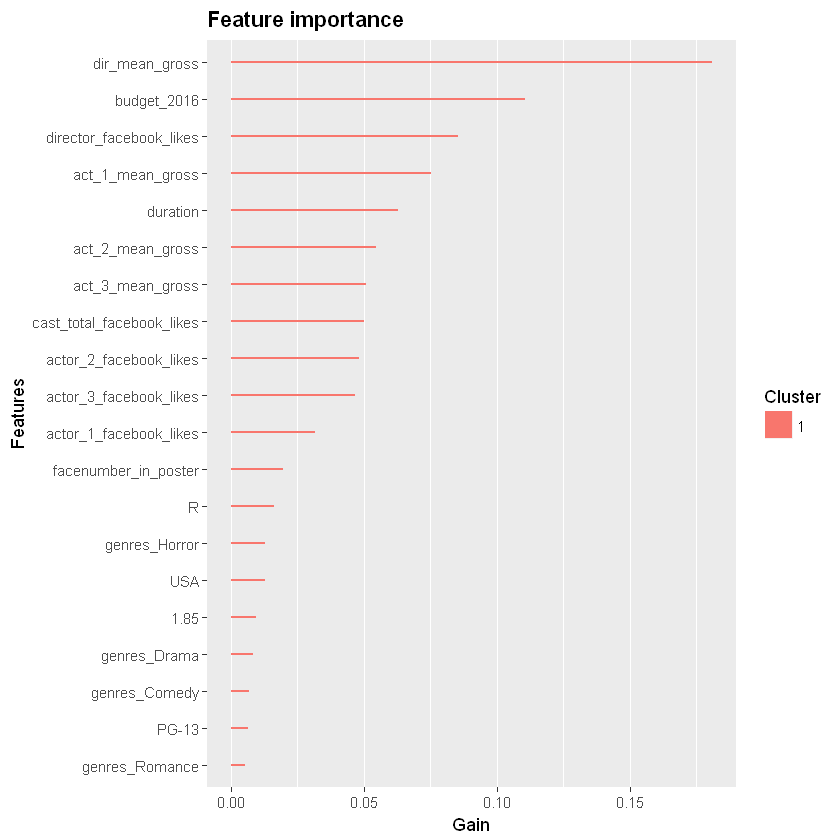

In [392]:
importance_matrix <- xgb.importance(dimnames(train_xgb_log[,!c("profitable","profit"),with=FALSE])[[2]], model = model_xgb_log)
xgb.plot.importance(importance_matrix[1:20])

We can see that most of the 274 variables have little or no influence on the model. In consequence, I will keep only the 20 variables with the most importance. 

In [393]:
names_var_log<-c(importance_matrix[1:30,Feature],"profitable","profit")
train_xgb_log<-train_xgb_log[,names_var_log,with=FALSE]
test_xgb_log<-test_xgb_log[,names_var_log,with=FALSE]

In [394]:
train_xgb_log_mat <- xgb.DMatrix(data.matrix(train_xgb_log[,!c("profitable","profit"),with=FALSE]), 
                                 label=train_xgb_log$profitable,missing=-1)
test_xgb_log_mat <- xgb.DMatrix(data.matrix(test_xgb_log[,!c("profitable","profit"),with=FALSE]), 
                                label=test_xgb_log$profitable,missing=-1)

Then I do a cross validation to determine which value of the hyperparameter of the algorithm. I started by the ETA.

### ETA

The eta is a parameter that prevent overfitting by scaling down the weigth of each feature after each iteration. I used a 5 fold cross validation process with 5 round after which the averages of the mean error is calculated for the prediction of the train a test set.

In [395]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,0.99,0.01)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=i, data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [396]:
head(xgb_mse_log)

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
2,0.00,0.2687690,0.0030040,0.2687650,0.0120120
21,0.01,0.2106102,0.0053150,0.2681410,0.0089248
3,0.02,0.2093326,0.0061988,0.2669412,0.0091132
4,0.03,0.2079380,0.0070086,0.2673060,0.0083570
5,0.04,0.2055914,0.0078950,0.2664192,0.0101324
6,0.05,0.2041578,0.0088464,0.2653764,0.0110574


The plot below show the average mean classification error for the prediction of the test set made with different value of eta from 0 to 1. 

In [397]:
xgb_log_eta_mse_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the eta parameter',
         xaxis = list(title = 'eta', zeroline = TRUE),
         yaxis = list(title = 'rmse'))
embed_notebook(xgb_log_eta_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_log_eta_mse_plot",".html"))

In [398]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
45,0.44,0.1779068,0.0050786,0.2552106,0.0093492


Since the value of the parameter eta who minimise the mean error is 0.4 that is the value I'll use for the model.

### Alpha

Alpha is a regularization term use in the linear version of xgboost. To find the most appropriete value to use in the model, I used the same cross validation process than before.

In [399]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,20,0.1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha = i, 
                                data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [400]:
xgb_log_alpha_mse_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the alpha parameter',
         xaxis = list(title = 'Alpha', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_alpha_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_log_eta_alpha_plot",".html"))

In [401]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
54,5.3,0.2010814,0.0055086,0.2479624,0.0113454


### Lambda

Like alpha, lambda is another regularization parameter that prevent overfitting problem.

In [402]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,10,0.1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha = 4.8, lambda=i,
                                data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [403]:
head(xgb_mse_log)

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
2,0.0,0.1972888,0.0043234,0.2517156,0.0126984
21,0.1,0.1974190,0.0043068,0.2515590,0.0127742
3,0.2,0.1970148,0.0049518,0.2509336,0.0117240
4,0.3,0.1968976,0.0048442,0.2513510,0.0118268
5,0.4,0.1973148,0.0050204,0.2505686,0.0117064
6,0.5,0.1977450,0.0041752,0.2505162,0.0119040


In [404]:
xgb_log_alpha_mse_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the alpha parameter',
         xaxis = list(title = 'Alpha', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_alpha_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_log_alpha_plot",".html"))

In [405]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
14,1.3,0.1988656,0.0050564,0.2486386,0.0145952


### gamma 

This parameter is the minimum loss reduction that need to occurs for the partition of a tree. That parameter can take any value greater or equal to 0 and the greater the value, the more conservative the model will be.  

In [406]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,10,0.1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha = 4.8, lambda=5,
                                gamma=i,data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [407]:
xgb_log_gamma_mse_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the gamma parameter',
         xaxis = list(title = 'gamma', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_gamma_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_log_gamma_plot",".html"))

In [408]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
23,2.2,0.2130214,0.0051100,0.2463468,0.0111840
25,2.4,0.2142726,0.0053868,0.2463468,0.0112264


### max_depth

As his name indicate that parameter set the maximun depth of each tree. This parameter take value greater or equal to 1.

In [410]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(1,50,1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha = 4.8, lambda=5,
                                gamma=0.1,max_depth=i,data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [411]:
xgb_log_max_depth_mse_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the max_depth parameter',
         xaxis = list(title = 'max_depth', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_max_depth_mse_plot,file=paste0("plotlyJupyterHTML/","xgb_log_max_depth_plot",".html"))

In [416]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
2,55,0.2380474,0.00488,0.2473398,0.0086426


As 6 is the defaul value of the parameter max_depth and that value minimise the mean error during the cross validation, I didn't change the defaut value.

### min_child_weight

This parameter determine the minimun weight that can have a tree after a partition during the creation of the model. Before each partition, the algorithm verify if the resulting child tree would have a weight smaller than that value and if it's the case, he doesn't do the partition. This parameter can take value greater than 0 and the bigger the value the more conservative the model will be.

In [417]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,150,0.5)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha = 4.8, lambda=5,
                                gamma=0.1,min_child_weight=i,data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [418]:
xgb_log_min_child_weight_expl<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the min_child_weight parameter',
         xaxis = list(title = 'min_child_weight', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_min_child_weight_expl,file=paste0("plotlyJupyterHTML/","xgb_log_min_child_weight_expl",".html"))

We see that there a minimum around min_child_weight=60, so I focus on this area of the graph.

In [419]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(55,70,0.1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha = 4.8, lambda=5,
                                gamma=0.1,min_child_weight=i,data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [420]:
xgb_log_min_child_weight_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the min_child_weight parameter',
         xaxis = list(title = 'min_child_weight', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_min_child_weight_plot,file=paste0("plotlyJupyterHTML/","xgb_log_min_child_weight_plot",".html"))

In [421]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
2,55,0.2380474,0.00488,0.2473398,0.0086426


Since all those value would minimise the mean classification error, I used min_child_weight=62.

### max_delta_step

max_delta_step is the maximum variation of the weight that we allow between two iterations of the algorithm. This value could be 0 (no constraint) or greater (more conservative).  

In [422]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,10,0.1)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha = 4.8, lambda=5,gamma=0.1,
                                min_child_weight=62,max_delta_step=i,data = train_xgb_log_mat,eval_metric= "error",
                                nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [423]:
xgb_log_max_delta_step_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the max_delta_step parameter',
         xaxis = list(title = 'max_delta_step', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_max_delta_step_plot,file=paste0("plotlyJupyterHTML/","xgb_log_max_delta_step_plot",".html"))

Since the default value of the parameter give the minimun mean error, I won't modify this value in the function.

### subsample 
This is the ratio of the sample during the training of the model. This parameter can take value between 0 and 1 (included).

In [424]:
xgb_mse_log<-data.frame(index=numeric(0),train.rmse.mean=numeric(0),train.rmse.std=numeric(0),
                    test.rmse.mean=numeric(0),test.rmse.std=numeric(0))

for (i in seq(0,1,0.01)){
    set.seed(383)
     model_xgb_log_cv <- xgb.cv(objective= "binary:logistic", eta=0.4, alpha = 4.8, lambda=5,,gamma=0.1,
                                min_child_weight=62, subsample=i,data = train_xgb_log_mat,
                                eval_metric= "error",nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_log<-rbind(xgb_mse_log,c("index"=i,lapply( model_xgb_log_cv,function(x) mean(x))))
}

In [425]:
xgb_log_subsample_plot<-plot_ly(xgb_mse_log) %>%
add_trace(x=~index,y=~test.error.mean, type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Value of the mean error during the cross validation of the subsample parameter',
         xaxis = list(title = 'subsample', zeroline = TRUE),
         yaxis = list(title = 'Mean error'))
embed_notebook(xgb_log_subsample_plot,file=paste0("plotlyJupyterHTML/","xgb_log_subsample_plot",".html"))

In [426]:
xgb_mse_log[xgb_mse_log$test.error.mean==min(xgb_mse_log$test.error.mean,na.rm=TRUE),]

,index,train.error.mean,train.error.std,test.error.mean,test.error.std
96,0.95,0.240563,0.005243,0.2482244,0.0108298


Now that I know which value of the hyperparameter to use, I can test the new model.

In [433]:
param_tune <- list(     objective= "binary:logistic", 
                        eta=0.4,
                        alpha = 4.8, 
                        lambda=5,
                        gamma=0.1, 
                        min_child_weight=35.5,
                        subsample=0.9, 
                        colsample_bytree=1                
                )

In [434]:
set.seed(383)
model_xgb_log_tune <- xgb.train(    params              = param_tune, 
                                    data                = train_xgb_log_mat, 
                                    nrounds             = 500, 
                                    eval_metric         = "error", 
                                    missing             =-1,
                                    verbose             = 0,
                                    maximize            = FALSE)

In [435]:
prediction<-data.frame(profit=test_xgb_log$profitable)
prediction$output<-NA

In [436]:
for (rows in split(1:nrow(test_xgb), ceiling((1:nrow(test_xgb))/10000))) {
    prediction[rows, "output"] <- predict(model_xgb_log_tune, test_xgb_log_mat)
    }

In [437]:
prediction$pred<-0
prediction[which(prediction$output>=0.5),"pred"]<-1
prediction$index<-seq.int(nrow(prediction))
prediction<-prediction[!is.na(test$gross_2016),]

result<-table(prediction$profit,prediction$pred)
result

   
      0   1
  0 553  66
  1 175  69

In [438]:
print(paste0("Accuracy: ",(result[1,1]+result[2,2])/sum(result)))
print(paste0("Precision: ",(result[2,2])/(result[2,2]+result[2,1])))
print(paste0("Recall: ",(result[2,2])/(result[2,2]+result[1,2])))

[1] "Accuracy: 0.720741599073001"
[1] "Precision: 0.282786885245902"
[1] "Recall: 0.511111111111111"


In [439]:
xgb.save(model_xgb_log,fname="model_xgb_log")

[1] TRUE

# Neural Network

The last algorithm I used is a simple neural network. To do so, I created two new set for training the neural network and testing the model. I choosed to include the continous and genre feature, since a network too complex couldn't be trained in a timely matter by my old computer.

In [441]:
train_nn<-train[,c(cont_var,genre_var),with=FALSE]
test_nn<-test[,c(cont_var,genre_var),with=FALSE]

train_nn$profitable<-0
test_nn$profitable<-0

train_nn[which(train_nn$profit>=0),"profitable"]<-1
test_nn[which(test_nn$profit>=0),"profitable"]<-1

The neural network I will use won't be able to handle the missing data. In consequence, I delete thos observations from the set.

In [442]:
train_nn<-train_nn[complete.cases(train_nn)]
test_nn<-test_nn[complete.cases(test_nn)]

Next I normalize the continuous variables and I drop the "profit" and "gross_2016" variables.

In [443]:
for (f in cont_var) {
  if (max(train_nn[[f]])!=1 | min(train_nn[[f]])!=-1) {
    train_nn[[f]] <- scale(train_nn[[f]])
    test_nn[[f]]  <- scale(test_nn[[f]])
  }
}

In [445]:
train_nn<-train_nn[,!c("profit","gross_2016"),with=FALSE]
test_nn<-test_nn[,!c("profit","gross_2016"),with=FALSE]

Below I defined the model I want to create with the neural network.

In [460]:
n <- names(train_nn)
f <- as.formula(paste("profitable ~", paste(n[!n %in% "profitable"], collapse = " + ")))

In [461]:
f

profitable ~ duration + director_facebook_likes + actor_3_facebook_likes + 
    actor_1_facebook_likes + cast_total_facebook_likes + facenumber_in_poster + 
    actor_2_facebook_likes + budget_2016 + dir_mean_gross + act_1_mean_gross + 
    act_2_mean_gross + act_3_mean_gross + genres_Action + genres_Adventure + 
    genres_Animation + genres_Biography + genres_Comedy + genres_Crime + 
    genres_Documentary + genres_Drama + genres_Family + genres_Fantasy + 
    genres_Film_Noir + genres_Game_Show + genres_History + genres_Horror + 
    genres_Music + genres_Musical + genres_Mystery + genres_News + 
    genres_Reality_TV + genres_Romance + genres_Sci_Fi + genres_Short + 
    genres_Sport + genres_Thriller + genres_War + genres_Western

Before I train the neural network, I must choose the number of hidden layer I'll use, the number of neuron in those layer and the value of the regularization parameter alpha. Since that adding redondant hidden layer give marginal improvement on the neural network, exept in rare occasion or when a lot is added, I chosed one hidden layer. To test how many neuron will be in that layer, I have written a function to easily test multiple value.

In [454]:
test.neuron<-function(n)
{
    index <- sample(1:nrow(train_nn),round(0.85*nrow(train_nn)))
    train.cv <- train_nn[index,]
    cross.val.cv <- train_nn[-index,]
    
    nn <- neuralnet(f,data=train.cv,hidden=n,algorithm= 'rprop+',learningrate=0.01,
                    err.fct = "sse",act.fct = "logistic",linear.output=FALSE)
    pred<-compute(nn, cross.val.cv[,!"profitable",with=FALSE])
    output<-round(pred$net.result)
    result<-sum((cross.val.cv$profitable-output)^2)

    return(result)
}

There's 39 features

In [462]:
test.layer<-NULL
for (i in 5*(3:9)){
    test.layer<-c(test.layer,test.neuron(i))
}
test.layer

[1] 194 160 173 174 191 183 204

In [16]:
test.layer

NULL

In [463]:
test.learning.rate<-function(n)
{
    index <- sample(1:nrow(train_nn),round(0.9*nrow(train_nn)))
    train.cv <- train_nn[index,]
    cross.val.cv <- train_nn[-index,]
    
    nn <- neuralnet(f,data=train.cv,hidden=25,algorithm= 'rprop+',learningrate=n,
                    err.fct = "sse",act.fct = "logistic",linear.output=FALSE)
    pred<-compute(nn, cross.val.cv[,!"profitable",with=FALSE])
    output<-round(pred$net.result)
    result<-sum((cross.val.cv$profitable-output)^2)
    
    return(result)
}

In [464]:
test.lr<-NULL
learning.rate<-c(0.01,0.007,0.005,0.002,0.001)
for (i in (learning.rate)){
    test.lr<-c(test.lr,test.learning.rate(i))
}
test.lr

[1] 129 113 120 124 119

In [474]:
set.seed(383)
initial_weight <- runif(1240, -(1/sqrt(39)),(1/sqrt(39)))

In [477]:
nn <- neuralnet(f,data=train_nn,hidden=30,algorithm= 'rprop+',stepmax=10000000,startweights =initial_weight,
                    err.fct = "sse",act.fct = "logistic",linear.output=FALSE)

In [476]:
pred<-compute(nn, test_nn[,!"profitable",with=FALSE])
    output<-round(pred$net.result)
    sse<-sum((test_nn$profitable-output)^2)
sse
result<-table(test_nn$profitable,output)
result
print(paste0("Accuracy: ",(result[1,1]+result[2,2])/sum(result)))

[1] 289

   output
      0   1
  0 195 165
  1 124 209

[1] "Accuracy: 0.582972582972583"


In [17]:
xgb_mse<-data.frame(index=as.numeric(0),train.rmse.mean=as.numeric(0),train.rmse.std=as.numeric(0),
                    test.rmse.mean=as.numeric(0),test.rmse.std=as.numeric(0))

for (i in seq(0.1,0.9,0.01)){
    set.seed(383)
    model_xgb_cv <- xgb.cv(params=param, eta=i, data = train_xgb_matrix, nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse<-rbind(xgb_mse,c("index"=i,lapply(model_xgb_cv,function(x) mean(x))))
}

In [18]:
xgb_mse1<-plot_ly(xgb_mse) %>%
add_trace(x=~index,y=~test.rmse.mean, name = 'trace 0', type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Trend line of the proportion ofmovie\'s color in the IMDB data set over the year',
         xaxis = list(title = 'eta', zeroline = TRUE),
         yaxis = list(title = 'rmse'))
embed_notebook(xgb_mse1,file=paste0("plotlyJupyterHTML/","xgb_mse1",".html"))

In [19]:
set.seed(383)
model_xgb_1_tune <- xgb.train(   params          = param, 
                    data                  = train_xgb_matrix, 
                    eta                   = 0.34,
                    nrounds               = 500, 
                    verbose               = 0, 
                    early_stopping_rounds = 20,
                    missing               = -1,
                    maximize              = FALSE)

In [20]:
pred<-predict(model_xgb_1_tune,test_xgb_matrix)
scaleList <- list(scale = attr(train_xgb$gross_2016, "scaled:scale"),
    center = attr(train_xgb$gross_2016, "scaled:center"))

pred_unscale <- pred * scaleList$scale + scaleList$center
error<-pred_unscale-test_xgb$gross_2016
rmse(error)

[1] 95464241

In [12]:
for (f in variable_names) {
  if (class(train_xgb[[f]])=="character") {
    levels <- unique(c(train_xgb[[f]],cross_val_xgb[[f]],test_xgb[[f]]))
    train_xgb[[f]] <- as.numeric(factor(train_xgb[[f]], levels=levels))
    cross_val_xgb[[f]] <- as.numeric(factor(cross_val_xgb[[f]], levels=levels))
    test_xgb[[f]]  <- as.numeric(factor(test_xgb[[f]],  levels=levels))
  }
}

In [46]:
xgb_mse_2<-data.frame(index=as.numeric(0),train.rmse.mean=as.numeric(0),train.rmse.std=as.numeric(0),
                    test.rmse.mean=as.numeric(0),test.rmse.std=as.numeric(0))

for (i in seq(0.1,0.9,0.01)){
    set.seed(383)
     model_xgb_cv <- xgb.cv(params=param, eta=i, data = train_xgb_matrix, nfold = 5, nrounds = 5, missing=-1,verbose= 0)
    xgb_mse_2<-rbind(xgb_mse_2,c("index"=i,lapply( model_xgb_cv,function(x) mean(x))))
}

In [47]:
xgb_mse2<-plot_ly(xgb_mse_2) %>%
add_trace(x=~index,y=~test.rmse.mean, name = 'trace 0', type = 'scatter',mode = 'lines+markers' )%>%
layout(title = 'Trend line of the proportion ofmovie\'s color in the IMDB data set over the year',
         xaxis = list(title = 'eta', zeroline = TRUE),
         yaxis = list(title = 'rmse'))
embed_notebook(xgb_mse2,file=paste0("plotlyJupyterHTML/","xgb_mse2",".html"))

In [48]:
set.seed(383)
model_xgb_2_tune <- xgb.train(   params          = param, 
                    data                  = train_xgb_matrix, 
                    eta                   = 0.25,
                    nrounds               = 500, # changed from 300
                    verbose               = 0, 
                    early_stopping_rounds = 20,
                    missing               = -1,
                    maximize              = FALSE)

In [49]:
pred<-predict(model_xgb_2_tune,test_xgb_matrix)
scaleList <- list(scale = attr(train_xgb$gross_2016, "scaled:scale"),
    center = attr(train_xgb$gross_2016, "scaled:center"))

pred_unscale <- pred * scaleList$scale + scaleList$center
error<-pred_unscale-test_xgb$gross_2016
rmse(error)

[1] 83849994

# XGBoost tree

Since the XGBoost algorithm give good result, I

Create 4 class: higly profitable(3), profitable(2), non-profitable(1), higly non-profitable(0)

In [127]:
train_xgb$profitable<-0
test_xgb$profitable<-0

train_xgb[which(train_xgb$profit>=0),"profitable"]<-1 
test_xgb[which(test_xgb$profit>=0),"profitable"]<-1

In [128]:
train_tree_mat <- xgb.DMatrix(data.matrix(train_xgb[,!c("profitable","profit"),with=FALSE]), 
                              label=train_xgb$profitable,missing=-1)
test_tree_mat <- xgb.DMatrix(data.matrix(test_xgb[,!c("profitable","profit"),with=FALSE]), 
                             label=test_xgb$profitable,missing=-1)

In [129]:
watchlist <- list(eval = test_tree_mat , train=train_tree_mat )

In [130]:
param <- list(  objective           = "multi:softmax", 
                num_class           = 2,
                eta                 = 0.01,
                max_depth           = 14,  
                #subsample           = 0.6,
                #colsample_bytree    = 0.6,
                eval_metric         = "merror"
                # alpha = 0.0001, 
                # lambda = 1
                )

In [131]:
set.seed(383)
model_xgb_tree <- xgb.train(   params        = param, 
                    data                     = train_tree_mat, 
                    nrounds                  = 500, # changed from 300
                    verbose                  = 2, 
                    early_stopping_rounds    = 20,
                    watchlist                = watchlist,
                    missing                  =NA,
                    maximize                 = FALSE)

Warning message:
"'early.stop.round' is deprecated.
Use 'early_stopping_rounds' instead.
See help("Deprecated") and help("xgboost-deprecated")."

[10:25:18] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 0 pruned nodes, max_depth=14
[10:25:18] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 0 pruned nodes, max_depth=14
[1]	eval-merror:0.341641	train-merror:0.081214 
Multiple eval metrics are present. Will use train_merror for early stopping.
Will train until train_merror hasn't improved in 20 rounds.

[10:25:18] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 874 extra nodes, 0 pruned nodes, max_depth=14
[10:25:18] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 874 extra nodes, 0 pruned nodes, max_depth=14
[2]	eval-merror:0.323988	train-merror:0.036845 
[10:25:18] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=14
[10:25:18] amalgamation/../src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes,

In [132]:
model.xgb.tree.cv<- xgb.cv(data = train_tree_mat,params=param, nfold = 100,nrounds = 2, missing=-1)
model.xgb.tree.cv

[1]	train-merror:0.081003+0.005405	test-merror:0.314113+0.075735 
[2]	train-merror:0.069269+0.008364	test-merror:0.313650+0.077467 


##### xgb.cv 100-folds
 iter train_merror_mean train_merror_std test_merror_mean test_merror_std
    1        0.08100288      0.005405426        0.3141132      0.07573513
    2        0.06926909      0.008364049        0.3136498      0.07746738

In [133]:
prediction<-data.frame(profit=test_xgb$profitable)
prediction$output<-NA

In [134]:
for (rows in split(1:nrow(test_xgb), ceiling((1:nrow(test_xgb))/10000))) {
    prediction[rows, "output"] <- predict(model_xgb_tree, test_tree_mat)
    }

In [135]:
prediction$index<-seq.int(nrow(prediction))
head(prediction)

profit,output,index
0,0,1
0,0,2
0,1,3
1,0,4
0,0,5
0,0,6


In [136]:
result<-table(prediction$profit,prediction$output)
result

   
      0   1
  0 620  87
  1 194  62

In [137]:
print(paste0("Accuracy: ",(result[1,1]+result[2,2])/sum(result)))

[1] "Accuracy: 0.708203530633437"


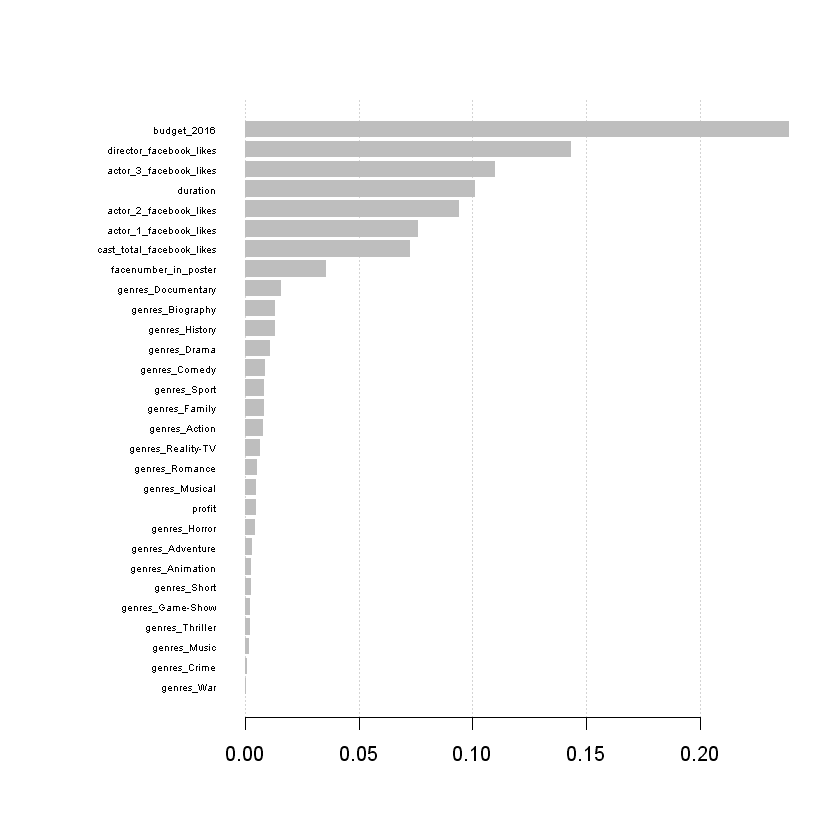

In [138]:
importance_matrix <- xgb.importance(dimnames(train_xgb)[[2]], model = model_xgb_tree)
xgb.plot.importance(importance_matrix)

In [139]:
xgb.save(model_xgb_tree,fname="model_xgb_tree")

[1] TRUE